# ATML2021 Assignment 2 Thomas Buchegger

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm import tqdm
from nms import nms
import os
import cv2 # pip install opencv-python

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Train a convolutional neural network for binary classification
Your network will learn to classify 48x48 patches into two classes: noface/face. Instructions in the pdf.

In [91]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose

target_size = (48, 48)
batch_size = 64

transforms = Compose([ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

# Load train data
train_dir = 'train'
train_dataset = ImageFolder(train_dir, transform=transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

val_dir = 'train'
val_dataset = ImageFolder(val_dir, transform=transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

classes = ('bg', 'face')

In [5]:
# show some images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

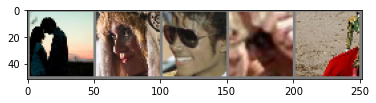

      bg     face     face     face       bg


In [6]:
# get some random training images
show_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
dataiter = iter(show_train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

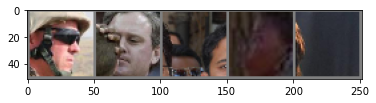

    face     face       bg     face       bg


In [7]:
# get some random validation images
show_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=True)
dataiter = iter(show_val_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

In [8]:
#Network
import torch.nn as nn
    
class ConvModel(nn.Module):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1)
        )
    
    def forward(self, input):
        output = self.conv_layers(input)
        output = output.view(output.size(0), -1)
        return output

In [9]:
def train_epoch(model, dataloader, optimizer, loss_fn):
    trainLosses = []
    correct_predictions = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        # Log metrics
        trainLosses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(trainLosses).mean()
    return mean_loss, accuracy

In [10]:
def evaluate(model, dataset_loader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataset_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataset_loader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

In [11]:
def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [12]:
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(np.arange(n_epochs), train_losses, color='blue')
    plt.plot(np.arange(n_epochs), val_losses, color='green')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curves (training/validation)')
    plt.grid(False, color='w', linestyle='-', linewidth=2)
    plt.gca().patch.set_facecolor('0.8')

    plt.figure()
    plt.plot(np.arange(n_epochs), train_accuracies, color='blue')
    plt.plot(np.arange(n_epochs), val_accuracies, color='green')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy curves (training/validation)')
    plt.grid(True, color='w', linestyle='-', linewidth=2)
    plt.gca().patch.set_facecolor('0.8')

In [17]:
conv_model = ConvModel()
conv_model = conv_model.to(device)
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.0003)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses, val_losses, train_acc, val_acc = train(conv_model, train_loader, val_loader, optimizer, n_epochs, loss_fn)

100%|██████████| 1396/1396 [01:32<00:00, 15.13it/s]
Epoch 10/10: train_loss: 0.0714, train_accuracy: 97.2912, val_loss: 0.0571, val_accuracy: 97.9449


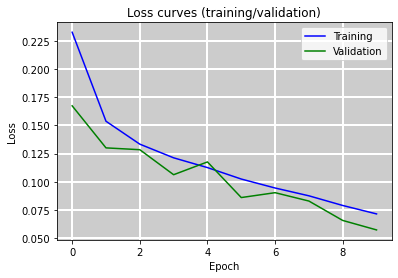

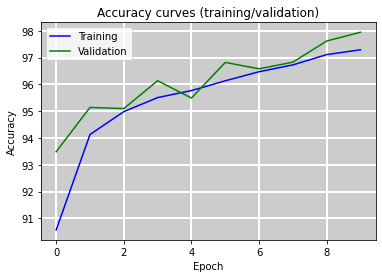

In [18]:
plot(n_epochs, train_losses, val_losses, train_acc, val_acc)

# 2. Implement fully convolutional face detector that uses the binary classifier
Use your trained binary classification model for face detection in bigger images.  
Follow the instructions in the pdf and in the comments 

In [102]:
class FullyConvolutionalDetector:
    def __init__(self, model, max_res=1024, scales=[1.0, 0.8, 0.6, 0.4, 0.2, 0.1], threshold=0.5):
        self.model = model
        self.max_res = max_res
        self.scales = scales
        self.threshold = threshold
    
    @torch.no_grad()
    def detect_single_scale(self, image):
        '''Run a fully convolutional model on the input image'''
        '''Image is assumed to be of shape HxWx3 and scaled to [0,1]'''
        ## TODO
        ## Preprocess the image (subtract and divide as in training)

        img_size = (48, 48)
        img_shape_0 = image.shape[0]
        img_shape_1 = image.shape[1]
        face_coordiantes = []
        face_probabilities = []

        # mn = np.min(image)
        # mx = np.max(image)
        # image = (ar - mn) * (1.0 / (mx - mn))
        for x in range(int((img_shape_0 - img_size[0]) / 10)):
            for y in range(int((img_shape_1 - img_size[1]) / 10)):
                img = image[x * 10: x * 10 + img_size[0], y * 10: y * 10 + img_size[1]]

                ## Convert the image to a tensor of shape 1x3xHxW; move it to the same device as the model
                # image = transforms(image)
                # image = image.view(1, 3, image.size(2), image.size(1))
                # image = image.to(device)
                
                image_trans = transforms(img)
                image_trans = image_trans.unsqueeze(0)
                image_trans = image_trans.to(device)


                ## Run the self.model on the image
                model_output = self.model(image_trans)

                ## Process the output with softmax (torch.softmax) on the channel dimension
                import torch.nn.functional as F
                prob = F.softmax(model_output, 1)

                ## Get probabilities for the face class (discard the non-face class)
                face_probs = prob[0].cpu().detach().numpy()

                ## Find output coordinates where the face probability > self.threshold
                ## (hint: you can convert output to numpy and use np.where)
                if face_probs[1] > self.threshold:
                    ## Convert selected output coordinates to input coordinates 
                    input_coords = (y * 10 + img_size[1], x * 10 + img_size[0], y * 10, x * 10)
                    ## You should return coordinates as a numpy array of shape Nx4 (N - detected faces)
                    ## each row are coordinates x1, y1, x2, y2 - top left and bottom right corner of a rectangle
                    face_coordiantes.append(input_coords)
                    face_probabilities.append(face_probs[1])

        face_coordiantes = np.array(face_coordiantes)
        face_probabilities = np.array(face_probabilities)
        ## Return face coordinates and their probabilities
        return face_coordiantes, face_probabilities
    
    @torch.no_grad()
    def detect_multi_scale(self, image, my_nms=True):
        '''Run the detector on a pyramid of images (same image in different scales)'''
        all_face_coordinates = []
        all_face_probabilities = []
        for scale in self.scales:
            H, W, C = image.shape
            scale_factor = float(self.max_res) / max(H, W) * scale
            ## TODO resize the image by scale_factor (e.g. cv2.resize, convert to PIL.Image and resize...)
            resized_img = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
            
            ## Run detect_single_scale on resized image
            resized_face_cooords, resized_face_probs = self.detect_single_scale(resized_img)
            
            ## Scale back the returned face coordinates to original image coordinates
            resized_face_cooords = resized_face_cooords / scale_factor
            resized_face_probs = resized_face_probs / scale_factor
            
            ## Append detected face coordinates and probabilities to all_face_coordinates and probabilities
            if resized_face_cooords.size != 0:
                all_face_coordinates.append(resized_face_cooords)
                all_face_probabilities.append(resized_face_probs)
            
        all_face_coordinates = np.concatenate(all_face_coordinates, 0)
        all_face_probabilities = np.concatenate(all_face_probabilities)
        if my_nms==True and len(all_face_coordinates) > 0: # merge overlapping predictions
            results = np.concatenate((all_face_coordinates, all_face_probabilities.reshape(-1,1)),1)
            results = nms(results, 0.3) 
            all_face_coordinates = results[:,:4]
            all_face_probabilities = results[:,4]
        return all_face_coordinates, all_face_probabilities

In [103]:
def read_images(img_dir, box_dir):
    # Returns a list of numpy array with images from img_dir scaled from [0, 1]
    # and a list of face bounding boxes (coordinates) for each image
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    box_files = [os.path.join(box_dir, f.replace('.jpg','.txt')) for f in img_files]
    img_files = [os.path.join(img_dir, f) for f in img_files]
    
    images = [np.array(Image.open(f)).astype(np.float32)/255 for f in img_files]
    boxes = [np.loadtxt(f, ndmin=2).astype(np.int32) for f in box_files]
    return images, boxes

def draw_boxes_with_gt(image, boxes, gt_boxes=None):
    img_draw = image.copy()
    for box in boxes:
        cv2.rectangle(img_draw,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0),
                      2)
    if gt_boxes is not None:
        for box in gt_boxes:
            cv2.rectangle(img_draw,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0,1,0),
                          2)
    plt.figure(figsize=(12,6))
    plt.imshow(img_draw)

In [104]:
# Run evaluation on images from full_images folder; follow the instructions from the pdf
images, boxes = read_images("full_images", "full_boxes")

In [105]:
fully_conv_detector = FullyConvolutionalDetector(conv_model, threshold=0.99)

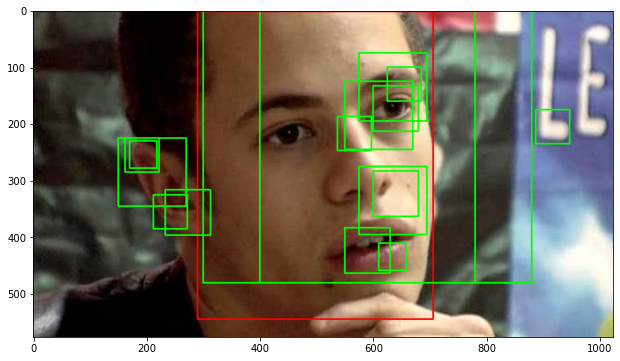

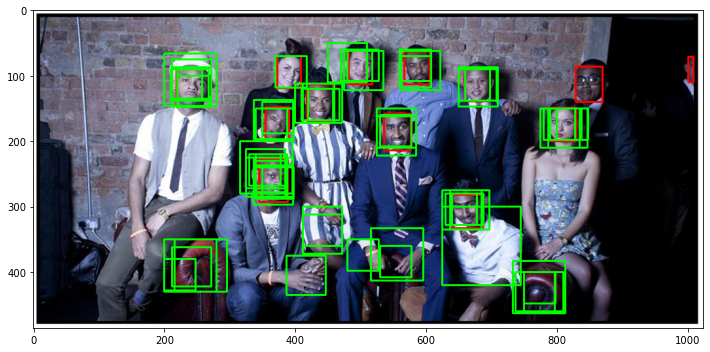

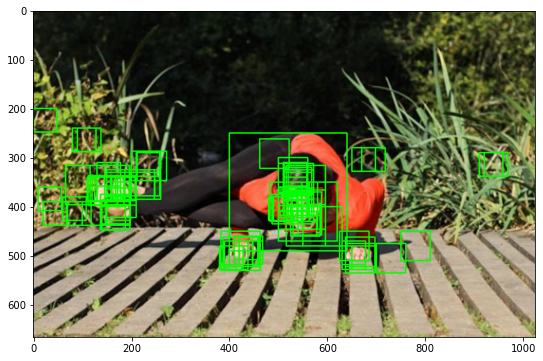

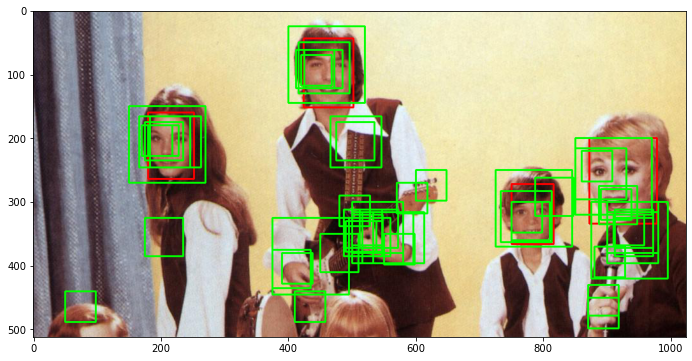

In [106]:
for image, box in zip(images, boxes):
    all_face_coordinates, all_face_probabilities = fully_conv_detector.detect_multi_scale(image)
    draw_boxes_with_gt(image, box, all_face_coordinates)

In [108]:
for image, box in zip(images, boxes):
    all_face_coordinates, all_face_probabilities = fully_conv_detector.detect_multi_scale(image, my_nms=False)
    draw_boxes_with_gt(image, box, all_face_coordinates)

TypeError: function takes exactly 4 arguments (2 given)

# 3. Improve your model
Propose different improvements and train new models (follow instructions from the pdf)